In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem Statement

In this Premier Project, we will analyse & visualize the data to identify the pattern of churner and non-churners to help banks retain their customers. The cost of retaining the customer is way much less than acquiring new customers. In such business, banks wants to understand the significant hidden pattern of customer churning. This will help bank to concentrate on the pattern and make interesting the strategies such as offering new services, discounted loans, healthcare services etc. around it to retain the customer. We have to use EDA to analyse the patterns present in the data.

In [1]:
# Libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

%matplotlib inline

## 1.0 Data Import

In [2]:

try:
    df = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv")
except:
    df = pd.read_csv("BankChurners.csv")
df.head(2)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

## 2.0 Data Wrangling

In [4]:
drop_col = ["CLIENTNUM", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"]
df = df.drop(columns=drop_col)
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [5]:
# Dict of the unique values in each column
column_dict = {}
for col in df.columns:
    column_dict[col] = df[col].unique()

In [6]:
# Remove "Unknown" data
df_copy =df.copy()
for col in df_copy.columns:
    df_copy=df_copy[df_copy[col] !="Unknown"]
    
column_dict = {}
for col in df_copy.columns:
    column_dict[col] = df_copy[col].unique()
    
column_dict
df_copy.shape

(7081, 20)

In [7]:
df_copy["Attrition_Flag"] = df_copy["Attrition_Flag"].replace({"Existing Customer": 0, "Attrited Customer":1})
print(df_copy.Attrition_Flag.unique())
print(df_copy["Attrition_Flag"].sum())


[0 1]
1113


## 3.0 Exploratory Data Analysis

### Check distribution of variables

* Dependent Variable (Target)

In [8]:
df_copy["Attrition_Flag"].value_counts(normalize=True)

0    0.842819
1    0.157181
Name: Attrition_Flag, dtype: float64

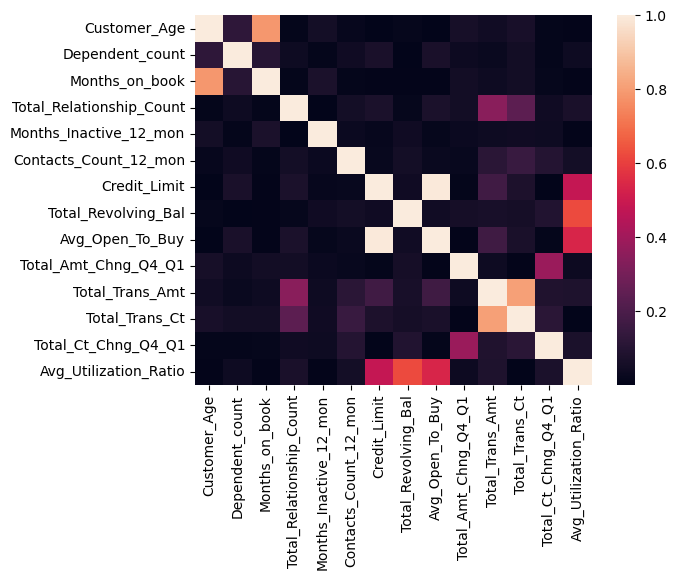

In [9]:
corr = abs(df.select_dtypes("number").corr())
sns.heatmap(corr);

There is a high correlation between 2 of the independent variables; `Credit_Limit` and `Avg_Open_To_Buy`

From the above distribution, it is observed we have an imbalance (84% negative class to 16% positive class) in the target variable, and the data might need to be resampled to achieve a balance.

* Independent Variables (Features)

In [10]:
# List Categorical Columns
cat_columns = df_copy.columns[df_copy.dtypes == "object"]
cat_columns

Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

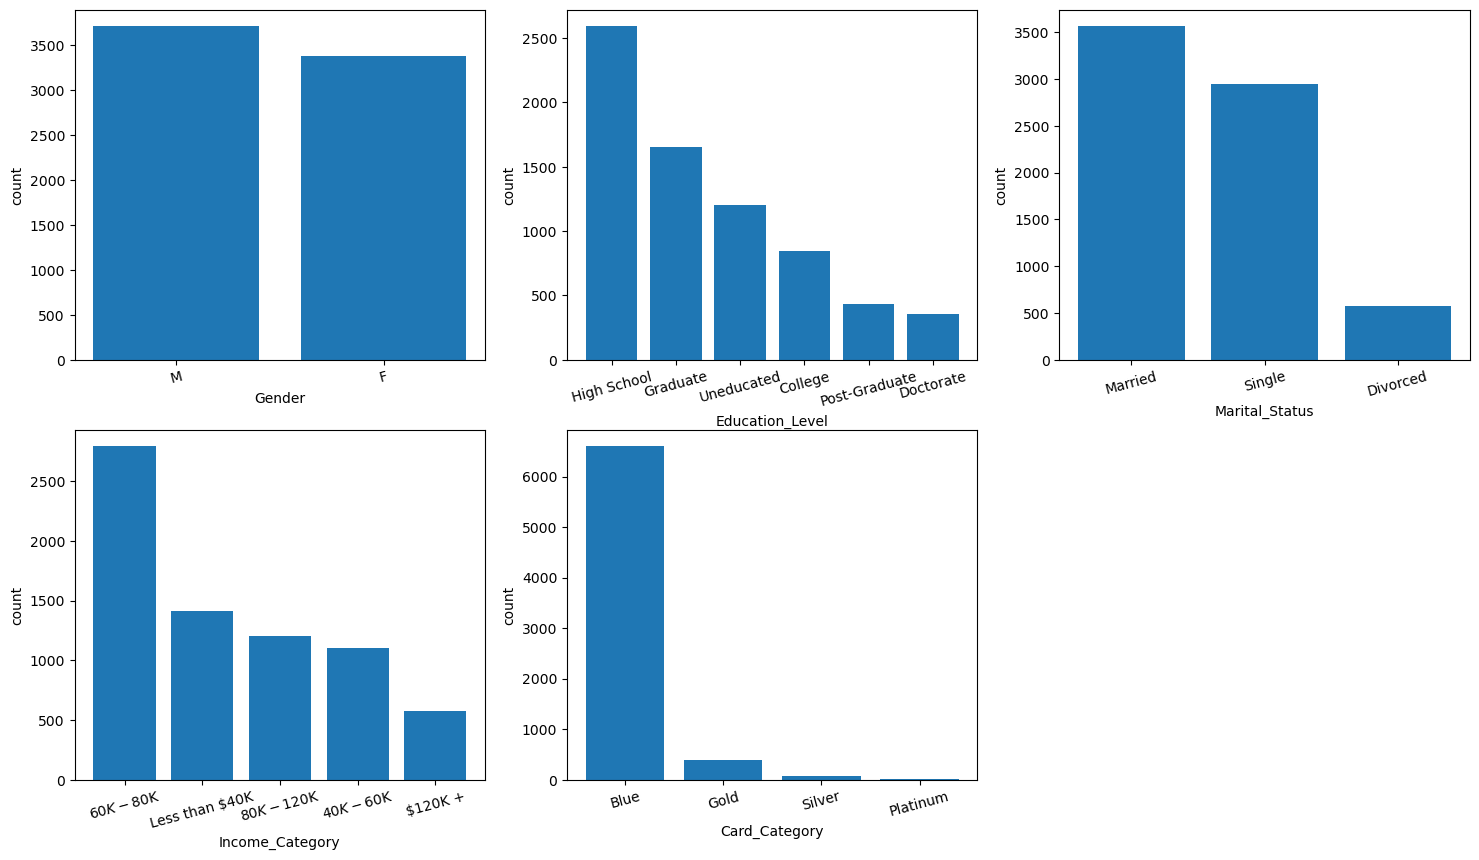

In [11]:
# categorical columns barplot function
plt.figure(figsize=[18,10])

def cat_barplot(col, position):
    plt.subplot(position)
    plt.bar( x = df_copy[col].unique(), height=df_copy[col].value_counts())
    plt.xticks(rotation = 15)
    plt.xlabel(f'{col}')
    plt.ylabel("count")

# Plot Gender column
cat_barplot("Gender", 231)
cat_barplot("Education_Level", 232)
cat_barplot("Marital_Status", 233)
cat_barplot("Income_Category", 234)
cat_barplot("Card_Category", 235)

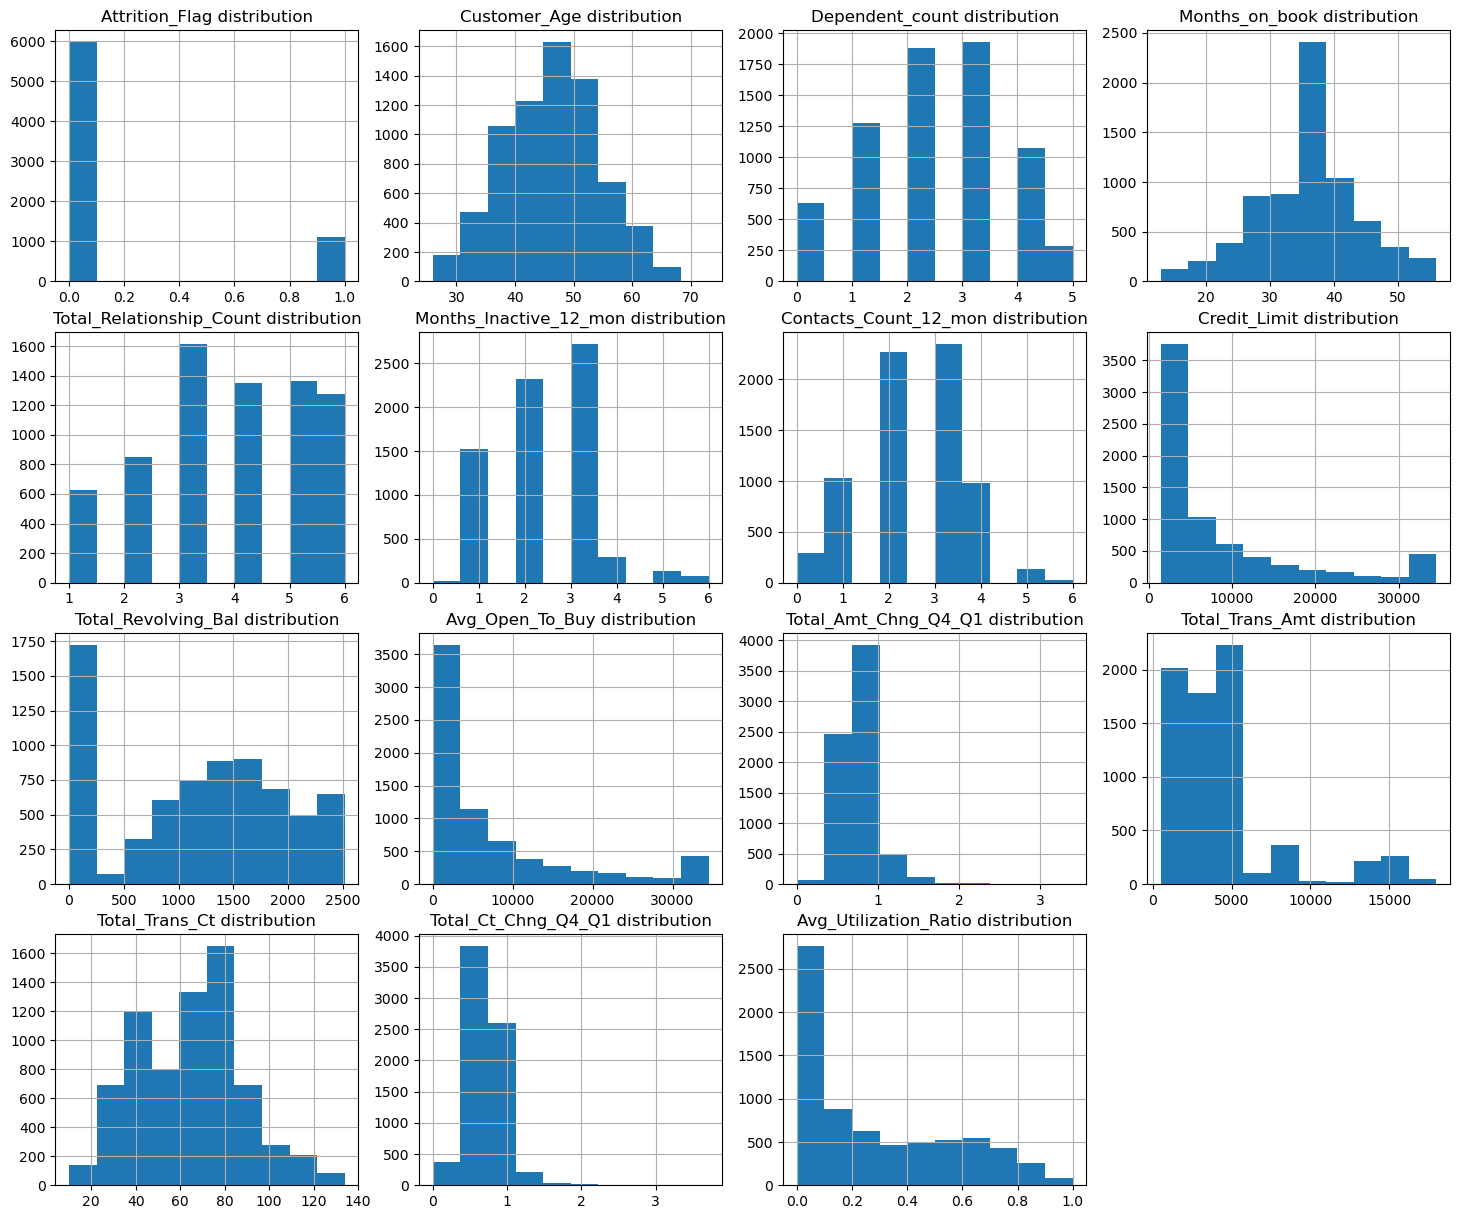

In [12]:
num_columns = df_copy.columns[df_copy.dtypes != "object"]

plt.figure(figsize=[18,15])

n=1
for col in num_columns:
    plt.subplot(4,4,n)
    df_copy[col].hist()
    plt.title(f'{col} distribution')
    n=n+1


### Insights

- Churning rate is 16%
- Gender is almost equally distributed in the data
- Graduate and Married are high in data
- Most customer have less than $40K income
- Customers with Blue card category are highest and platinum category are least

### Features-Target, Tain-Test Split.

In [13]:
# Define the function we will require for encoding our data

# To encode binary columns(Gender& Attrition_Flag)
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

# To encode ordinal columns(Education_Level & Income_category)
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

# To encode nominal columns(Marital_Status & Card_Category)
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(column, axis=1)
    return df

In [14]:
def preprocess_input(df):
    df = df.copy()
    
    # drop the last two columns according to the instructions of the dataset
    df = df.drop(df.columns[-2:], axis=1)
    
    # Convert the unknow values into np.NaN
    df = df.replace('Unknown', np.NaN)
    
    # drop the null values from the df
    df = df.dropna()
    
    # Encode binary columns
    df = binary_encode(df, 'Attrition_Flag', positive_value='Attrited Customer')
    df = binary_encode(df, 'Gender', positive_value='M')
    
    # Encode ordinal columns
    education_ordering = [
                'Uneducated',    
                'High School',
                'College',
                'Graduate',
                'Post-Graduate',
                'Doctorate'
    ]
    income_ordering =[
            'Less than $40K',
            '$40K - $60K',
            '$60K - $80K',
            '$80K - $120K',
            '$120K +'
    ]
    df = ordinal_encode(df, 'Education_Level', ordering=education_ordering)
    df = ordinal_encode(df, 'Income_Category', ordering=income_ordering)
    
    # Encode nominal columns
    df = onehot_encode(df, 'Marital_Status', prefix='Marital')
    df = onehot_encode(df, 'Card_Category', prefix='Card')
    
    # drop CLIENTNUM all are unique
    df = df.drop('CLIENTNUM', axis=1)
    
    X = df.drop('Attrition_Flag', axis=1).copy()
    y = df['Attrition_Flag'].copy()
    
    # scale X with standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [17]:
try:
    data = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv")
except:
    data = pd.read_csv("BankChurners.csv")

In [18]:
X, y = preprocess_input(data)

In [19]:
X

,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Divorced,Marital_Married,Marital_Single,Card_Blue,Card_Gold,Card_Platinum,Card_Silver
0,-0.167610,0.954298,0.512710,-0.758658,0.484351,0.377234,0.764487,-1.349309,0.493777,0.460058,...,-0.945214,3.827331,-0.794057,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755
1,0.329862,-1.047890,2.061228,0.664969,-0.990784,1.002074,1.412015,-1.349309,-0.411332,-0.025947,...,-1.323244,12.579779,-0.636187,-0.295596,-1.006660,1.184047,0.270562,-0.107571,-0.039445,-0.241755
2,0.578598,0.954298,0.512710,0.664969,1.221918,0.002330,0.116959,-1.349309,-2.221550,-0.556114,...,-1.869287,6.793694,-1.012921,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755
3,-0.789449,0.954298,0.512710,-1.470471,0.484351,-1.872192,0.764487,-1.349309,-2.221550,-0.413874,...,-1.533260,7.493388,-1.012921,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755
4,-0.291978,0.954298,-0.261549,0.664969,-0.253217,0.002330,-0.530569,-1.349309,-0.411332,-0.491240,...,-1.701273,0.563494,0.102927,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076,0.951702,0.954298,-1.035808,-0.758658,0.484351,-0.247607,0.764487,-0.344317,-2.221550,0.596928,...,2.079024,0.178034,-0.471142,-0.295596,-1.006660,1.184047,0.270562,-0.107571,-0.039445,-0.241755
7077,1.200438,-1.047890,-1.035808,0.664969,-0.990784,1.751883,0.116959,-1.349309,1.398886,-0.526526,...,2.331044,0.333056,-0.424499,-0.295596,-1.006660,1.184047,0.270562,-0.107571,-0.039445,-0.241755
7078,0.454230,0.954298,-0.261549,0.664969,-0.253217,0.502202,-0.530569,-0.344317,0.493777,-0.492007,...,2.205034,0.609581,0.644706,-0.295596,-1.006660,1.184047,0.270562,-0.107571,-0.039445,-0.241755
7079,-0.291978,-1.047890,-1.035808,-0.758658,-0.990784,0.002330,0.764487,0.660674,1.398886,-0.337932,...,-0.189154,0.446180,-1.012921,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755


In [20]:
y

0        0
1        0
2        0
4        0
5        0
        ..
10120    0
10121    0
10122    0
10124    1
10126    1
Name: Attrition_Flag, Length: 7081, dtype: int64

In [21]:
# Train-test split with 0.2 test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (5664, 24)
X_test:  (1417, 24)
y_train:  (5664,)
y_test:  (1417,)


In [22]:
models = [
    SVC(),
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    LGBMClassifier(),
    XGBClassifier()
]

for model in models:
    model.fit(X_train, y_train)

C:\Users\damol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
model_names = [
    'SVC',
    'LogisticRegression',
    'KNeighborsClassifier',
    'RandomForestClassifier',
    'ExtraTreesClassifier',
    'LGBMClassifier',
    'XGBClassifier'
]

In [24]:
for model, name in zip(models, model_names):
    print(name + " : {:.4f}%".format(model.score(X_test, y_test)* 100))

SVC : 93.0134%
LogisticRegression : 90.6140%
KNeighborsClassifier : 90.9668%
RandomForestClassifier : 95.7657%
ExtraTreesClassifier : 93.9308%
LGBMClassifier : 97.2477%
XGBClassifier : 96.9654%


The model tha we use is LightGBMClassifier since it has the higher accuracy to predict if a customer will churn.

In [25]:
from sklearn.metrics import accuracy_score
# Fit the model on the training set
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy:.2f}')

Test set accuracy: 0.97


In [26]:
from sklearn.model_selection import cross_val_score

# Use 5-fold cross-validation to evaluate the model
scores = cross_val_score(LGBMClassifier(), X, y, cv=5)

# Print the mean and standard deviation of the scores
print(f'Cross-validation scores: {scores}')
print(f'Mean score: {scores.mean():.2f}')
print(f'Standard deviation: {scores.std():.2f}')

Cross-validation scores: [0.90684545 0.93714689 0.97457627 0.97528249 0.86016949]
Mean score: 0.93
Standard deviation: 0.04


In [27]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print(cm)

[[1196    9]
 [  30  182]]


In [28]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1205
           1       0.95      0.86      0.90       212

    accuracy                           0.97      1417
   macro avg       0.96      0.93      0.94      1417
weighted avg       0.97      0.97      0.97      1417



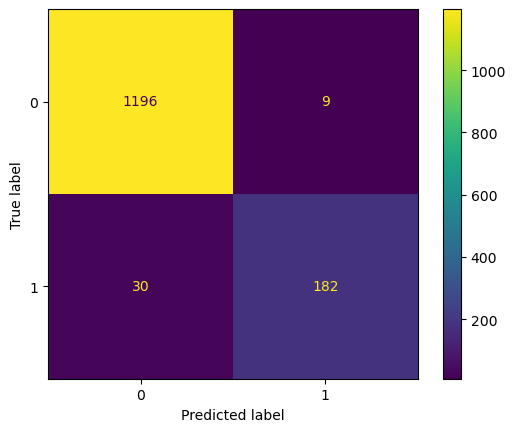

In [29]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

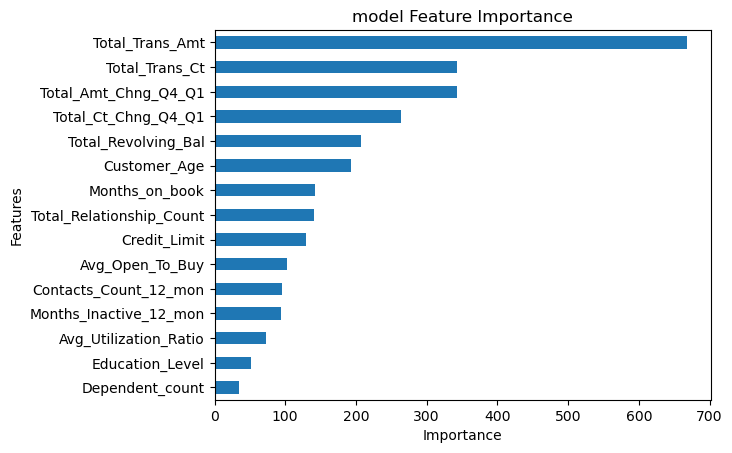

In [30]:
# Get importances
importances = model.feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index = X_train.columns).sort_values(key=abs)

# Plot series
feat_imp.tail(15).plot(kind = "barh")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("model Feature Importance");

### Hyperparameter Tuning

In [31]:
params = {
    "n_estimators": range(50, 126, 25), # range from 50 up to 125, with steps of 25
    "max_depth": range(2, 7, 2), # range from 2 up to 6, with steps of 2
    "num_leaves": range(8, 150, 20)
}
params

{'n_estimators': range(50, 126, 25),
 'max_depth': range(2, 7, 2),
 'num_leaves': range(8, 150, 20)}

In [32]:
model_inst = LGBMClassifier(random_state=42)
model_tuned = GridSearchCV(
    model_inst,
    param_grid=params,
    cv = 5,
    n_jobs=-1,
    verbose=1
    
)
model_tuned

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(2, 7, 2),
                         'n_estimators': range(50, 126, 25),
                         'num_leaves': range(8, 150, 20)},
             verbose=1)

In [35]:
%pip install imblearn
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

     ------------------------------------- 225.4/225.4 kB 66.5 kB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 kB 65.8 kB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.
X_train_over shape: (9526, 24)


,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Divorced,Marital_Married,Marital_Single,Card_Blue,Card_Gold,Card_Platinum,Card_Silver
0,1.076070,-1.047890,-0.261549,0.664969,-0.990784,0.752138,0.116959,0.660674,0.493777,-0.741749,...,0.104869,0.416851,-1.012921,-0.295596,-1.006660,1.184047,0.270562,-0.107571,-0.039445,-0.241755
1,0.454230,0.954298,-0.261549,0.664969,1.221918,-0.622511,-0.530569,0.660674,0.493777,0.483619,...,-0.105148,-0.676681,-0.923222,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755
2,-0.291978,0.954298,1.286969,0.664969,1.959486,0.002330,-1.178096,-0.344317,-1.316441,2.851727,...,0.902932,-0.618024,-0.844288,-0.295596,-1.006660,1.184047,-3.696005,-0.107571,-0.039445,4.136420
3,-1.162553,0.954298,1.286969,0.664969,0.484351,-0.747479,0.764487,0.660674,-0.411332,-0.648164,...,-0.021141,-0.785615,2.488904,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755
4,0.454230,-1.047890,-0.261549,0.664969,-0.990784,0.127298,-1.178096,-1.349309,-0.411332,-0.773057,...,0.776922,-0.073353,0.210565,-0.295596,0.993384,-0.844561,0.270562,-0.107571,-0.039445,-0.241755


In [36]:
y_train_over.value_counts()

0    4763
1    4763
Name: Attrition_Flag, dtype: int64

In [37]:
# Train model
model_tuned.fit(X_train_over, y_train_over)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(2, 7, 2),
                         'n_estimators': range(50, 126, 25),
                         'num_leaves': range(8, 150, 20)},
             verbose=1)

In [38]:
cv_results = pd.DataFrame(model_tuned.cv_results_)
cv_results.sample()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,0.404067,0.036432,0.027704,0.014865,6,50,28,"{'max_depth': 6, 'n_estimators': 50, 'num_leav...",0.973767,0.980052,0.975328,0.977428,0.984252,0.978165,0.003703,35


In [39]:
cv_results.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
90,1.272666,0.084764,0.063911,0.013247,6,125,48,"{'max_depth': 6, 'n_estimators': 125, 'num_lea...",0.983736,0.989501,0.983727,0.988451,0.992651,0.987613,0.003458,1
95,1.083061,0.081443,0.052488,0.010768,6,125,148,"{'max_depth': 6, 'n_estimators': 125, 'num_lea...",0.981637,0.988451,0.984252,0.989501,0.989501,0.986669,0.003174,2
91,1.355912,0.067524,0.075210,0.010582,6,125,68,"{'max_depth': 6, 'n_estimators': 125, 'num_lea...",0.981637,0.988451,0.984252,0.989501,0.989501,0.986669,0.003174,2
94,1.259354,0.093211,0.065308,0.013756,6,125,128,"{'max_depth': 6, 'n_estimators': 125, 'num_lea...",0.981637,0.988451,0.984252,0.989501,0.989501,0.986669,0.003174,2
93,1.281148,0.046682,0.069915,0.015747,6,125,108,"{'max_depth': 6, 'n_estimators': 125, 'num_lea...",0.981637,0.988451,0.984252,0.989501,0.989501,0.986669,0.003174,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.145452,0.011244,0.009601,0.000799,2,50,88,"{'max_depth': 2, 'n_estimators': 50, 'num_leav...",0.924449,0.937533,0.921785,0.922310,0.947507,0.930717,0.010179,89
3,0.137520,0.008878,0.012104,0.005479,2,50,68,"{'max_depth': 2, 'n_estimators': 50, 'num_leav...",0.924449,0.937533,0.921785,0.922310,0.947507,0.930717,0.010179,89
2,0.195432,0.016071,0.012002,0.003687,2,50,48,"{'max_depth': 2, 'n_estimators': 50, 'num_leav...",0.924449,0.937533,0.921785,0.922310,0.947507,0.930717,0.010179,89
1,0.198229,0.043147,0.010201,0.001467,2,50,28,"{'max_depth': 2, 'n_estimators': 50, 'num_leav...",0.924449,0.937533,0.921785,0.922310,0.947507,0.930717,0.010179,89


In [40]:
pd.Series(model_tuned.best_params_)

max_depth         6
n_estimators    125
num_leaves       48
dtype: int64

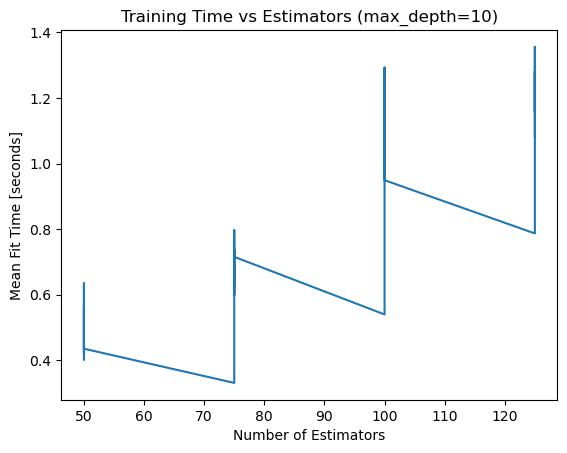

In [41]:
# Create mask
mask = cv_results["param_max_depth"]==6
# Plot fit time vs n_estimators
plt.plot(cv_results[mask]["param_n_estimators"], cv_results[mask]["mean_fit_time"])
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

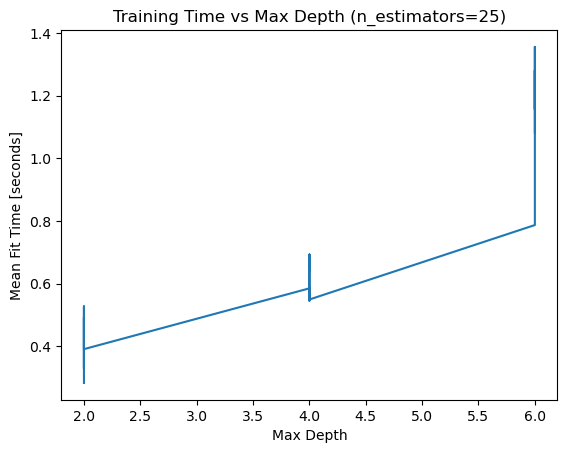

In [42]:
# Create mask
mask = cv_results["param_n_estimators"]==125
# Plot fit time vs max_depth
plt.plot(cv_results[mask]["param_max_depth"], cv_results[mask]["mean_fit_time"])
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

Note that we don't need to build and train a new model with these settings. Now that the grid search is complete, when we use `model.predict()`, it will serve up predictions using the best model

#### Evaluate tuned model

In [43]:
# Calculate the training and test accuracy scores for model_tuned.
acc_train = model_tuned.score(X_train, y_train)
acc_test = model_tuned.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9984
Test Accuracy: 0.9675


In [44]:
# Generate a classification report
report = classification_report(y_test, model_tuned.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1205
           1       0.88      0.91      0.89       212

    accuracy                           0.97      1417
   macro avg       0.93      0.94      0.94      1417
weighted avg       0.97      0.97      0.97      1417



For this project, according to the aim, a recall score is more important than the precision score. This is because we are more interested in capturing all the customers that are more likely to churn/attrite, even though we incorectly include those that are less likely to churn.

### **After tuning the hyperparameters, the recall score for our model (for the target/label) increased from 86% to 91% even though the precision score dropped from 95% to 88%**

## Communicate Results

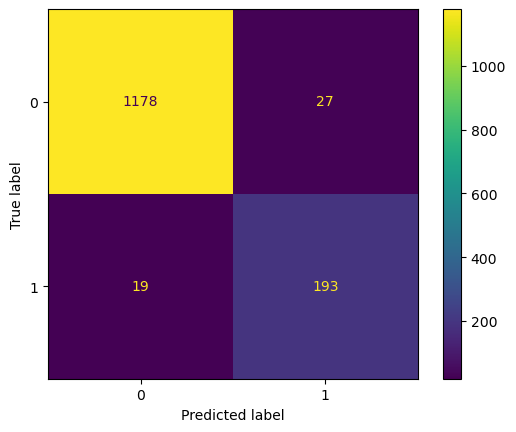

In [45]:
# Plot confusion matrix for the tuned model
ConfusionMatrixDisplay.from_estimator(model_tuned, X_test, y_test);

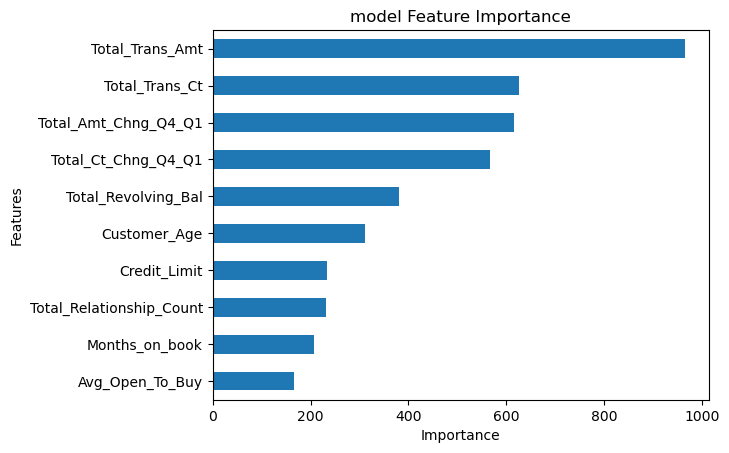

In [46]:
# Get importances
imp = model_tuned.best_estimator_.feature_importances_

# Put importances into a Series
feature_imp = pd.Series(imp, index = X_train.columns).sort_values(key=abs)

# Plot series
feature_imp.tail(10).plot(kind = "barh")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("model Feature Importance");

From the above, total *transaction amount and count* plays the most important role in determining if a customer will churn or not. Other futures like *total revolving balance, customer age, credit limit etc.,* also play a part in customers' decision.

Sometimes, communication means sharing a visualization and a report (as seen above). Other times, it means sharing the actual model. 

First step towards production: saving the model (as seen below).

In [47]:
# Saving the model as "model-team-azure.pkl"
with open("model-team-azure.pkl", "wb") as model_file:
    pickle.dump(model_tuned, model_file)

Using a context manager, the best-performing model was saved to a a file named `"model-team-azure.pkl"`. 